# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Image 6

In [34]:
image_path:str = "test_images/6.U.jpg"

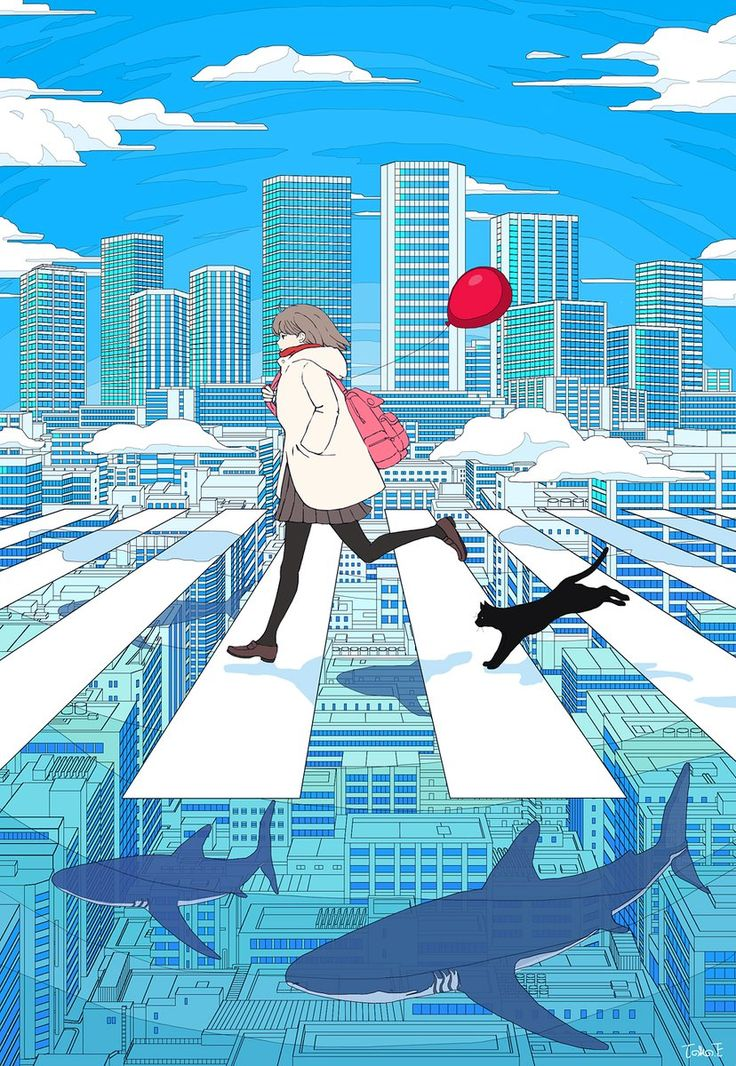

In [35]:
image = Image.open(image_path)
image

In [36]:
prompt :str = "<image>\nDescribe this picture concisely."

In [37]:
response(image_path,prompt)

Generated text:

In the image depicts a surreal scene takes place, a woman features a woman setting in a colorful city is a young girl of a young girl walking a woman running in an urban girl with a young woman walking girl walking scene set in a young girl and a girl flying with a girl walking cartoon walking through an Asian running up and a young woman walking in a girl and a cat walking through an anime walking through an anime walking on a girl and a young girl walking along a cat walking on a cartoon in a cartoon walking along a girl and a cat in a cat walking along a cartoon in a cat floating walking in a comic fantasy walking in a cat crossing a cartoon walking through a cat with a cat in a cat across a cat crossing a cat crossing a floating with a comic book a drawing a city running a black floating a cat crossing a cat crossing a floating in a cat crossing a drawing a drawing as a series jumping in the large standing a drawing drawing a drawing in a story a drawing a story a 

In [38]:
prompt :str = "<image>\nIs there anything unusual in this picture?"

In [39]:
response(image_path,prompt)

Generated text:

Yes, the unusual elements in this picture of the image, there is the presence of the image depicts a picture, there is that the picture, there are a image features the scene, there is the image features a is a scene scene, the unusual, there are multiple cartoon, there is that the unusual scene, there are several unusual things is a that a a surreal and a depiction is the presence picture, there are some unusual a scene surreal elements within the depiction, surreal and dream surreal and a picture surreal and surreal and city surreal and dream surreal nature, fantast, fantast, fantast and dream animation surreal and the, fantast, which nature, and dream, fantastistic urban, dream, depicting, dream-world, dream-like, fantastical, fantastical artwork, dreamlike, fantastical and dreamlike artwork, dreamlike, fantastical and dreamlike, depicting and dreamlike, depicting, dreamlike, dreamlike, dream-like, dream sequence, dream-like, elements, dreamlike, where, the, dream-li